In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Train with GPU support.")
else:
    device = torch.device('cpu')
    print("No GPU found, train with CPU support.")

import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt


# own utils
from utils.graph import *
from utils.tram_models import *
from utils.tram_model_helpers import *
from utils.tram_data import *
from utils.continous import *
from utils.sampling_tram_data import *

Train with GPU support.


# 1. Experiments and Paths

In [ ]:
experiment_name = "continous_4vars_1"   ## <--- set experiment name


DATA_PATH = "/home/bule/TramDag/data"
LOG_DIR="/home/bule/TramDag/dev_experiment_logs"
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)

# 2.  Data


- provide data in the form of a pandas dataframe, if there are iamges add the paths to each image to the df

Loaded data from /home/bule/TramDag/dev_experiment_logs/continous_4vars_1/continous_4vars_1.csv


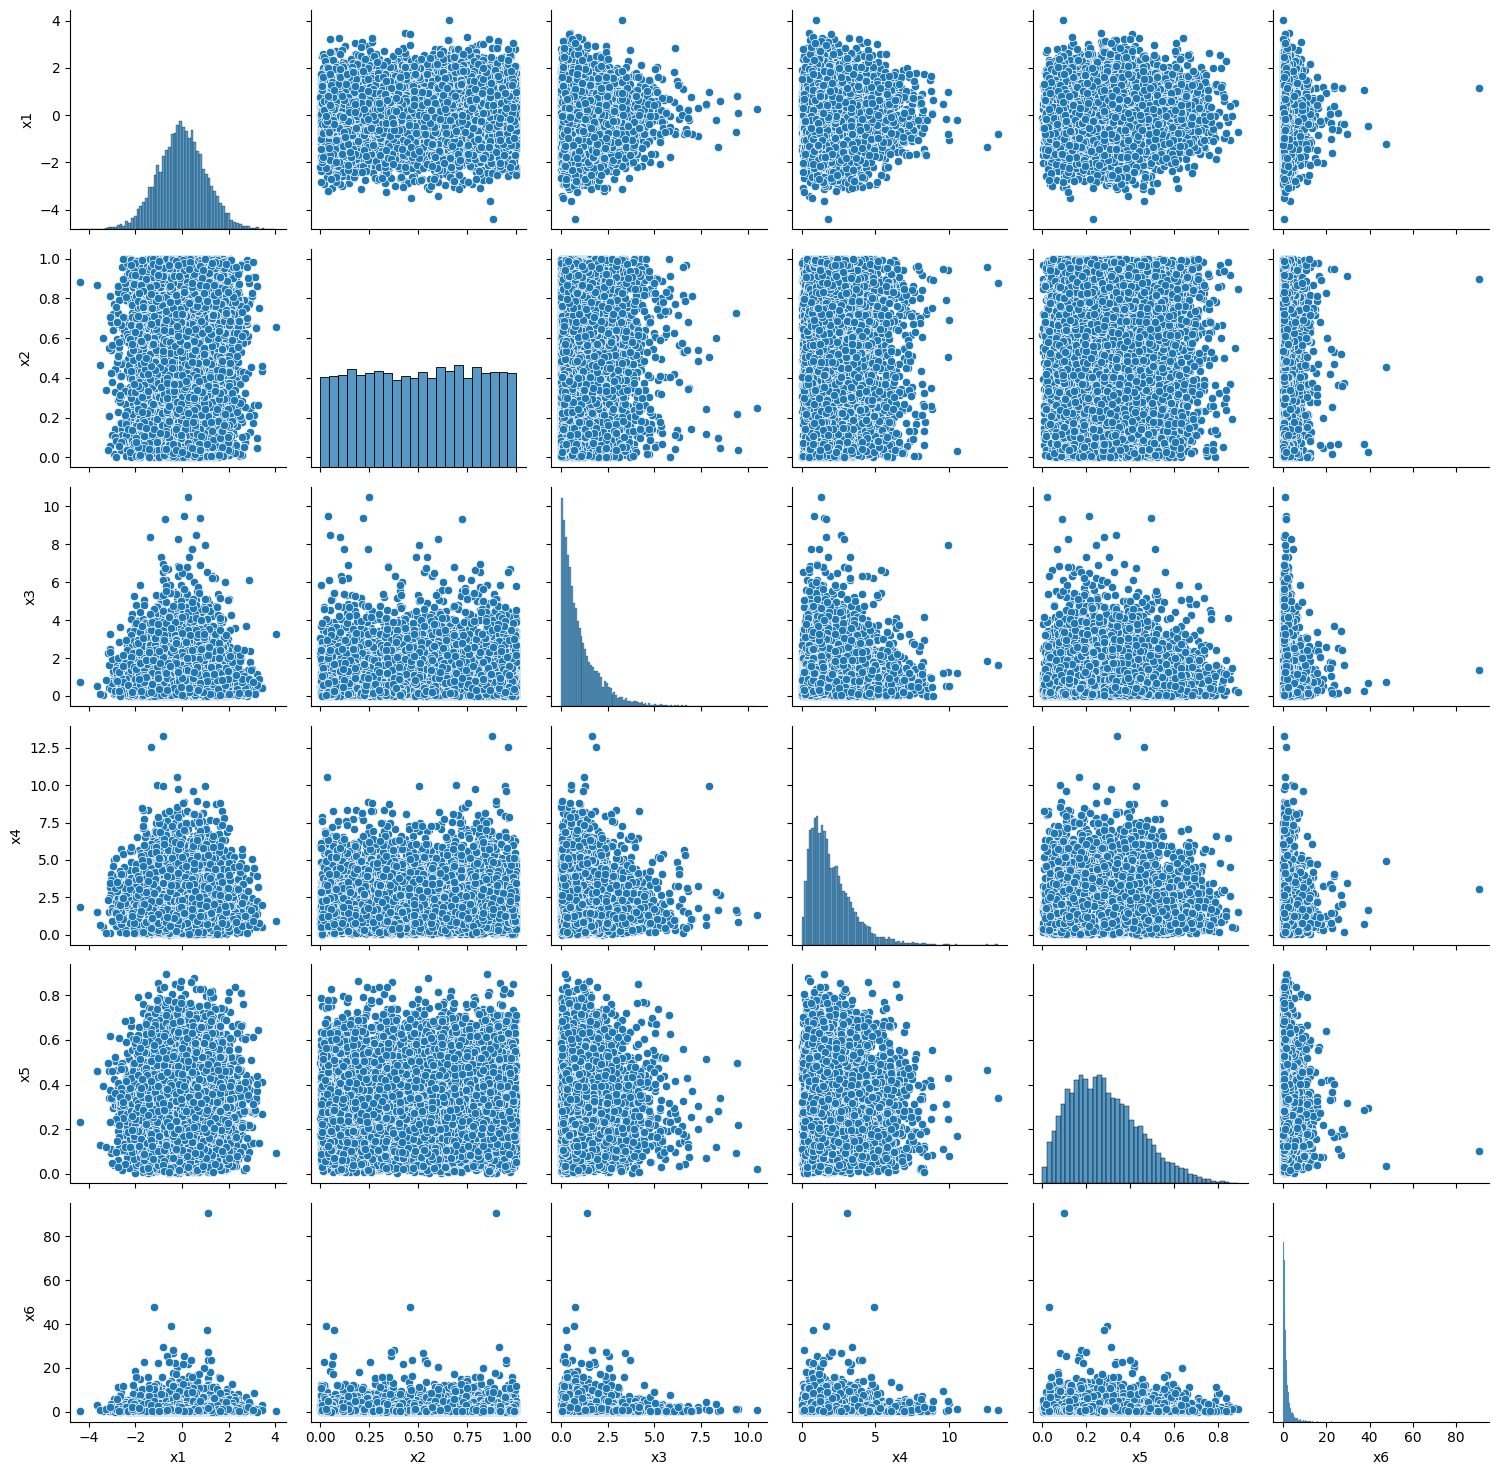

In [ ]:
EXP_DATA_PATH=os.path.join(EXPERIMENT_DIR, f"{experiment_name}.csv")

if not os.path.exists(EXP_DATA_PATH):
    print(f"Generating data for {experiment_name}...")
    # Config
    n_samples = 10_000
    n_features = 6
    rng = np.random.default_rng(seed=42)

    # Define different distributions
    distributions = [
        lambda n: rng.normal(loc=0, scale=1, size=n),         # standard normal
        lambda n: rng.uniform(low=0, high=1, size=n),          # uniform [0,1]
        lambda n: rng.exponential(scale=1.0, size=n),          # exponential
        lambda n: rng.gamma(shape=2.0, scale=1.0, size=n),     # gamma
        lambda n: rng.beta(a=2.0, b=5.0, size=n),              # beta
        lambda n: rng.lognormal(mean=0.0, sigma=1.0, size=n),  # log-normal
        lambda n: rng.chisquare(df=2, size=n),                 # chi-squared
        lambda n: rng.triangular(left=0.0, mode=0.5, right=1.0, size=n), # triangular
        lambda n: rng.weibull(a=2.0, size=n),                  # weibull
        lambda n: rng.pareto(a=2.5, size=n),                   # pareto
    ]
    # Create features
    X = np.column_stack([dist(n_samples) for dist in distributions[:n_features]])
    # Wrap in DataFrame
    feature_names = [f'x{i}' for i in range(1,n_features+1)]
    df = pd.DataFrame(X, columns=feature_names)
    df.to_csv(EXP_DATA_PATH, index=False)

else:
    df = pd.read_csv(EXP_DATA_PATH)
    print(f"Loaded data from {EXP_DATA_PATH}")

# Get min_vals and max_vals as torch tensors
quantiles = df.quantile([0.05, 0.95])
min_vals = quantiles.loc[0.05].values.astype(np.float32)
max_vals = quantiles.loc[0.95].values.astype(np.float32)
sns.pairplot(df)
plt.suptitle("", y=1.02)
plt.tight_layout()
plt.show()

### train test split

In [5]:
# train
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
# Validation and test
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 8000, Validation size: 1000, Test size: 1000


# 4. Define graph Structure

- define graph and which shift and intercept terms to use


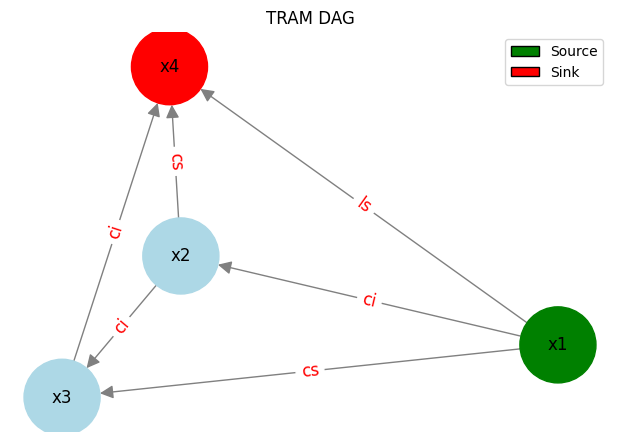

In [6]:
# describe if data is continous or  ordinal  ['cont', 'ord','other']
# note that other data than tabular can only be used as source 

# TODO support for interactions in CI model eg CI_1

# # Example 1 dgp tramdag paper  3x3: 
# data_type={'x1':'cont','x2':'cont','x3':'cont'}  # continous , images , ordinal
# adj_matrix = np.array([
#     [ "0", "ci", "ci"],  # A -> B (cs), A -> C (ls)
#     [ "0", "0", "cs"],  # B -> D (ls)
#     [ "0", "0", "0"],  # C -> D (cs)
# ], object)
# seed=5


# its also possible to have ci11 and ci12 etc to inlcude multiple varibales for a network for the intercept. aswell as for cs name it with ci11 ci12


# Example 1 dgp tramdag paper  3x3: 
data_type={'x1':'cont','x2':'cont','x3':'cont','x4':'cont'}  # continous , images , ordinal
adj_matrix = np.array([
    [ "0", "ci", "cs", "ls"],  # A -> B (cs), A -> C (ls)
    [ "0", "0",  "ci", "cs"],  # B -> D (ls)
    [ "0", "0",  "0" , "ci" ],
    [ "0", "0",  "0" , "0" ],# C -> D (cs)
], object)
seed=10

#TODO solve inf problem for x4 model prob due to x1 

# # example 2 6x6
# data_type={'x0':'cont','x1':'cont','x2':'cont','x3':'cont','x4':'cont','x5':'cont'}  # images, continous, continous, continous    
# adj_matrix = np.array([
#                                 ["0", "0", "0", "0", "ci", "ci"],  # A -> B (cs), A -> C (ls)
#                                 ["0", "0", "0"  , "0", "ci", "ci"],  # B -> D (ls)
#                                 ["0", "0", "0"  , "0", "0", "ci"],  # C -> D (cs)
#                                 ["0", "0", "0"  , "0", "0", "ci"],  # C -> D (cs)
#                                 ["0", "0", "0"  , "0" , "0", "ci"],
#                                 ["0", "0", "0"  , "0" , "0", "0"] # No outgoing edges from D
#                             ], dtype=object)


plot_dag(adj_matrix,data_type, seed=seed)

# 5. Configuration for the Models

- all SI and LS model are generated outmatically since these are shallow NN's
- CI and CS have to be defined by the User and can be Passed for each model, -> generate default networks which are generated automaitcally

************* 
 Model has Complex intercepts and Coomplex shifts , please add your Model to the modelzoo 
************


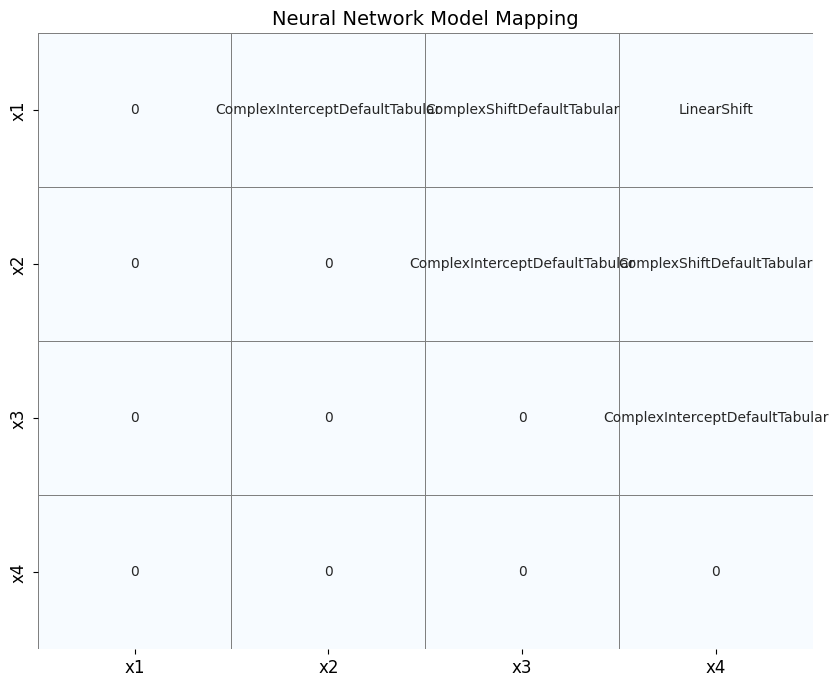

In [7]:
# check if there are Ci or Compelx shifts in the models. If yes define the modelnames
nn_names_matrix= create_nn_model_names(adj_matrix,data_type)
plot_nn_names_matrix(nn_names_matrix,data_type)

- add custom models for the ci or cs

In [8]:
# TODO: fucniton to automate
# if different models should be used, defin model in utils.models 
# e.g ComplexInterceptCUSTOMImage # any possible eg VITS

# rename the modelnames in the nn_names_matrix
# e.g.nn_names_matrix[2,3]='ComplexInterceptCUSTOMImage'  

- model configurations

In [ ]:
#TODO : OPTION write config to a argparser to  and args object to pass datatypes

conf_dict=get_configuration_dict(adj_matrix,nn_names_matrix, data_type)
# write min max to conf dict
for i,node in enumerate(data_type.keys()):
    conf_dict[node]['min']=min_vals[i].tolist()
    conf_dict[node]['max']=max_vals[i].tolist()
    

# write to file
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"{experiment_name}_conf.json")
with open(CONF_DICT_PATH, 'w') as f:
    json.dump(conf_dict, f, indent=4)
    
print(f"Configuration saved to {CONF_DICT_PATH}")

conf_dict

Configuration saved to /home/bule/TramDag/dev_experiment_logs/continous_4vars_1/continous_4vars_1_conf.json


{'x1': {'Modelnr': 0,
  'data_type': 'cont',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': {},
  'transformation_terms_in_h()': {},
  'transformation_term_nn_models_in_h()': {},
  'min': -1.67409348487854,
  'max': 1.64274001121521},
 'x2': {'Modelnr': 1,
  'data_type': 'cont',
  'node_type': 'internal',
  'parents': ['x1'],
  'parents_datatype': {'x1': 'cont'},
  'transformation_terms_in_h()': {'x1': 'ci'},
  'transformation_term_nn_models_in_h()': {'x1': 'ComplexInterceptDefaultTabular'},
  'min': 0.05174693092703819,
  'max': 0.9501002430915833},
 'x3': {'Modelnr': 2,
  'data_type': 'cont',
  'node_type': 'internal',
  'parents': ['x1', 'x2'],
  'parents_datatype': {'x1': 'cont', 'x2': 'cont'},
  'transformation_terms_in_h()': {'x1': 'cs', 'x2': 'ci'},
  'transformation_term_nn_models_in_h()': {'x1': 'ComplexShiftDefaultTabular',
   'x2': 'ComplexInterceptDefaultTabular'},
  'min': 0.05064348876476288,
  'max': 2.9887731075286865},
 'x4': {'Modelnr': 3,
  'data_typ

## 6. Fit models

- each model independently fitting

In [ ]:
DEV_TRAINING=True
train_list=['x1'] # <-  set the nodes which have to be trained , useful if further training is required

batch_size = 512 
epochs = 500     # <- if you want a higher numbe rof epochs, set the number higher and it loads the old model and starts from there
use_scheduler = True

In [ ]:
# For each NODE 
for node in conf_dict:
    # Skip if node is not in train_list
    if node not in train_list:
        print(f"Skipping node {node} as it's not in the training list.")
        continue
    
    print(f'\n----*----------*-------------*--------------- Node: {node} ------------*-----------------*-------------------*--')

    # Skip unsupported types
    if (conf_dict[node]['node_type'] == 'source') and (conf_dict[node]['node_type'] == 'other'):
        continue

    ########################## 1. Create Model ##############################
    tram_model = get_fully_specified_tram_model(node, conf_dict, verbose=True)
    tram_model = tram_model.to(device)

    ########################## 2. Create Dataloaders ########################
    train_loader, val_loader = get_dataloader(node, conf_dict, train_df, val_df, batch_size=32, verbose=True)

    ########################## 3. Setup Paths ###############################
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    os.makedirs(NODE_DIR, exist_ok=True)

    model_path = os.path.join(NODE_DIR, "best_model.pt")
    last_model_path = os.path.join(NODE_DIR, "last_model.pt")
    train_hist_path = os.path.join(NODE_DIR, "train_loss_hist.json")
    val_hist_path = os.path.join(NODE_DIR, "val_loss_hist.json")

    ########################## 4. Load Model & History ######################
    if os.path.exists(model_path) and os.path.exists(train_hist_path) and os.path.exists(val_hist_path):
        print("Existing model found. Loading weights and history...")
        tram_model.load_state_dict(torch.load(model_path))

        with open(train_hist_path, 'r') as f:
            train_loss_hist = json.load(f)
        with open(val_hist_path, 'r') as f:
            val_loss_hist = json.load(f)

        start_epoch = len(train_loss_hist)
        best_val_loss = min(val_loss_hist)
        print(f"Continuing training from epoch {start_epoch}...")
    else:
        print("No existing model found. Starting fresh...")
        train_loss_hist = []
        val_loss_hist = []
        start_epoch = 0
        best_val_loss = float('inf')

    # Skip if already trained
    if start_epoch >= epochs:
        print(f"Node {node} already trained for {epochs} epochs. Skipping.")
        continue

    ########################## 5. Optimizer & Scheduler ######################
    optimizer = torch.optim.Adam(tram_model.parameters(), lr=0.001, eps=1e-7, weight_decay=0.0)

    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)

    ########################## 6. Min/Max Tensor #############################
    min_vals = torch.tensor(conf_dict[node]['min'], dtype=torch.float32).to(device)
    max_vals = torch.tensor(conf_dict[node]['max'], dtype=torch.float32).to(device)
    min_max = torch.stack([min_vals, max_vals], dim=0)

    ########################## 7. Training Loop ##############################
    if DEV_TRAINING:
        for epoch in range(start_epoch, epochs):
            #### Training
            train_loss = 0.0
            tram_model.train()
            if use_scheduler:
                scheduler.step()

            for x, y in train_loader:
                optimizer.zero_grad()
            
                y = y.to(device)
                
                
                int_input, shift_list = preprocess_inputs(x, device=device)
                # print(f"train int_input: {int_input}")
                # print(f"train shift_list: {shift_list}")
                y_pred = tram_model(int_input=int_input,shift_input=shift_list)
                
                loss = contram_nll(y_pred, y, min_max=min_max)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            avg_train_loss = train_loss / len(train_loader)
            train_loss_hist.append(avg_train_loss)

            #### Validation
            val_loss = 0.0
            tram_model.eval()
            with torch.no_grad():
                for x, y in val_loader:
                    
                    y = y.to(device)

                    int_input, shift_list = preprocess_inputs(x, device=device)
                    # print(f"train int_input: {int_input}")
                    # print(f"train shift_list: {shift_list}")
                    y_pred = tram_model(int_input=int_input,shift_input=shift_list)
                    loss = contram_nll(y_pred, y, min_max=min_max)
                    val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            val_loss_hist.append(avg_val_loss)

            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

            #### Save Best Model
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(tram_model.state_dict(), model_path)
                print("Saved new best model.")

            #### Save Last Model
            torch.save(tram_model.state_dict(), last_model_path)

            #### Save Loss History
            with open(train_hist_path, 'w') as f:
                json.dump(train_loss_hist, f)
            with open(val_hist_path, 'w') as f:
                json.dump(val_loss_hist, f)



----*----------*-------------*--------------- Node: x1 ------------*-----------------*-------------------*--
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)


>>>>>>>>>>>>  source node --> x in dataloader contains just 1s 
Existing model found. Loading weights and history...
Continuing training from epoch 500...
Node x1 already trained for 500 epochs. Skipping.
Skipping node x2 as it's not in the training list.
Skipping node x3 as it's not in the training list.
Skipping node x4 as it's not in the training list.


(out['min'][0],out['max'][1])

- NLL curves

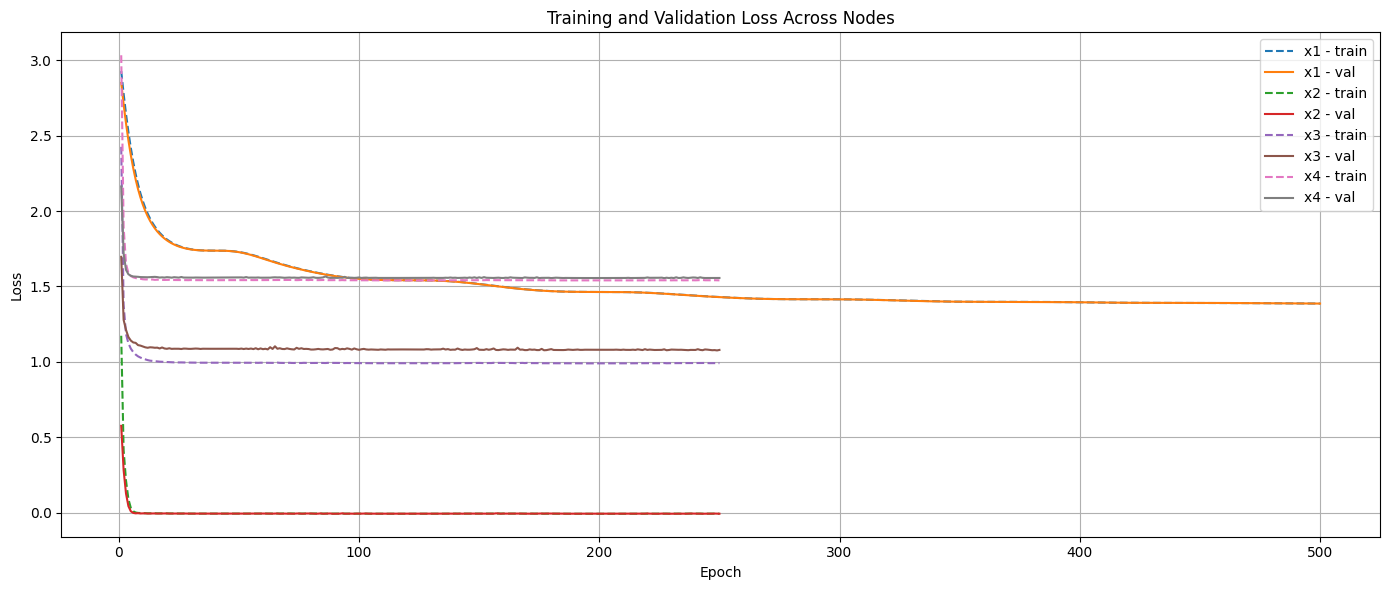

In [ ]:
plt.figure(figsize=(14, 6))
for node in conf_dict:
    train_hist, val_hist = load_history(node, EXPERIMENT_DIR)
    if train_hist is None or val_hist is None:
        print(f"No history found for node: {node}")
        continue

    epochs = range(1, len(train_hist) + 1)
    plt.plot(epochs, train_hist, label=f"{node} - train", linestyle="--")
    plt.plot(epochs, val_hist, label=f"{node} - val")

plt.title("Training and Validation Loss Across Nodes")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Sample from Graph

In [ ]:
n = 100_000  # Desired number of latent samples for starters
batch_size = 1
verbose=True

In [ ]:
for node in conf_dict:
    print(f'\n----*----------*-------------*--------Sample Node: {node} ------------*-----------------*-------------------*--')
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    SAMPLING_DIR=os.path.join(NODE_DIR, 'sampling')
    os.makedirs(SAMPLING_DIR,exist_ok=True)
    
    #checkk if parents are sampled already
    if check_roots_and_latents(NODE_DIR,verbose=verbose):
        continue
    
    skipping_node =False
    # check if node is source or not
    if conf_dict[node]['node_type'] == 'source':
        pass
    else:
        for parent in conf_dict[node]['parents']:
            if not check_roots_and_latents(os.path.join(EXPERIMENT_DIR, parent),verbose=verbose):
                skipping_node=True
                break
            
    if skipping_node:
        print(f"Skipping {node} as parent {parent} is not sampled yet.")
        continue
            
    
    #sampling from latent
    latent_sample = sample_standard_logistic((n,), device=device)
    if verbose:
        print("-- sampled latents")
    
    
    # load model 
    model_path = os.path.join(NODE_DIR, "best_model.pt")
    tram_model = get_fully_specified_tram_model(node, conf_dict, verbose=verbose)
    tram_model = tram_model.to(device)
    tram_model.load_state_dict(torch.load(model_path))
    if verbose:
        print("-- loaded modelweights")
    
    #Sampling Dataloader
    dataset = SamplingDataset(node=node,EXPERIMENT_DIR=EXPERIMENT_DIR,number_of_samples=n, conf_dict=conf_dict, transform=None)
    sample_loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)
    
    
    #Forward pass with the sampled data
    output_list = []
    with torch.no_grad():
        for x in tqdm(sample_loader, desc=f"Sampling {node}"):
            x = [xi.to(device) for xi in x]
            int_input, shift_list = preprocess_inputs(x, device=device)
            model_outputs = tram_model(int_input=int_input, shift_input=shift_list)
            output_list.append(model_outputs)

    if conf_dict[node]['node_type'] == 'source':
        
        if verbose:
            print("source node, Defaults to SI and 1 as inputs")
            
        theta_single =     output_list[0]['int_out'][0]  # Shape: (20,)
        theta_single=transform_intercepts_continous(theta_single)
        thetas_expanded = theta_single.repeat(n, 1)  # Shape: (n, 20)
        shifts = torch.zeros(n, device=device)
        
    else:
        
        if verbose:
            print("node has parents, previously sampled data is loaded for each pa(node)")
            
        y_pred=merge_outputs(output_list, skip_nan=True)
        shifts=y_pred['shift_out']
        if shifts is None:
            print("shift_out was None; defaulting to zeros.")
            shifts = torch.zeros(n, device=device)
        thetas=y_pred['int_out']
        thetas_expanded=transform_intercepts_continous(thetas).squeeze()
        shifts=shifts.squeeze()
        print(thetas_expanded.shape)
        print(shifts.shape)
        
        

    low = torch.full((n,), -1e5, device=device)
    high = torch.full((n,), 1e5, device=device)
    min_vals = torch.tensor(conf_dict[node]['min'], dtype=torch.float32).to(device)
    max_vals = torch.tensor(conf_dict[node]['max'], dtype=torch.float32).to(device)
    min_max = torch.stack([min_vals, max_vals], dim=0)
    

    ## Root finder
    root = bisection_root_finder(
    lambda targets: vectorized_object_function(
        thetas_expanded,
        targets,
        shifts,
        latent_sample,
        k_min=min_max[0],
        k_max=min_max[1]
    ),low,high, max_iter=10_000,tol=1e-10)
    
    #### Saving
    # save root and latents to 
    root_path = os.path.join(SAMPLING_DIR,"roots.pt")
    latents_path=os.path.join(SAMPLING_DIR, "latents.pt")
    
    if torch.isnan(root).any():
        print(f'caution! sampling for {node} consits of nans')
    
    torch.save(root, root_path)
    torch.save(latent_sample, latents_path)


----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/continous_4vars_1/x1/sampling
sampled latents
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)
loaded modelweights


Sampling x1: 100%|██████████| 100000/100000 [00:17<00:00, 5605.84it/s]


source node, Defaults to SI and 1 as inputs


Bisection root finding: 100%|██████████| 10000/10000 [01:04<00:00, 155.79it/s]



----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/continous_4vars_1/x2/sampling
sampled latents
>>> TRAM MODEL:
 TramModel(
  (nn_int): ComplexInterceptDefaultTabular(
    (fc1): Linear(in_features=1, out_features=8, bias=True)
    (relu1): ReLU()
    (fc2): Linear(in_features=8, out_features=8, bias=True)
    (relu2): ReLU()
    (fc3): Linear(in_features=8, out_features=20, bias=False)
  )
  (nn_shift): ModuleList()
)
loaded modelweights


Sampling x2: 100%|██████████| 100000/100000 [00:34<00:00, 2866.90it/s]


node has parents, previously sampled data is loaded for each pa(node)
shift_out was None; defaulting to zeros.
torch.Size([100000, 20])
torch.Size([100000])


Bisection root finding: 100%|██████████| 10000/10000 [01:05<00:00, 151.72it/s]



----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/continous_4vars_1/x3/sampling
sampled latents
>>> TRAM MODEL:
 TramModel(
  (nn_int): ComplexInterceptDefaultTabular(
    (fc1): Linear(in_features=1, out_features=8, bias=True)
    (relu1): ReLU()
    (fc2): Linear(in_features=8, out_features=8, bias=True)
    (relu2): ReLU()
    (fc3): Linear(in_features=8, out_features=20, bias=False)
  )
  (nn_shift): ModuleList(
    (0): ComplexShiftDefaultTabular(
      (fc1): Linear(in_features=1, out_features=8, bias=True)
      (relu1): ReLU()
      (fc2): Linear(in_features=8, out_features=8, bias=True)
      (relu2): ReLU()
      (fc3): Linear(in_features=8, out_features=1, bias=False)
    )
  )
)
loaded modelweights


Sampling x3: 100%|██████████| 100000/100000 [01:00<00:00, 1641.72it/s]


node has parents, previously sampled data is loaded for each pa(node)
torch.Size([100000, 20])
torch.Size([100000])


Bisection root finding: 100%|██████████| 10000/10000 [01:05<00:00, 152.99it/s]



----*----------*-------------*--------Sample Node: x4 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/continous_4vars_1/x4/sampling
sampled latents
>>> TRAM MODEL:
 TramModel(
  (nn_int): ComplexInterceptDefaultTabular(
    (fc1): Linear(in_features=1, out_features=8, bias=True)
    (relu1): ReLU()
    (fc2): Linear(in_features=8, out_features=8, bias=True)
    (relu2): ReLU()
    (fc3): Linear(in_features=8, out_features=20, bias=False)
  )
  (nn_shift): ModuleList(
    (0): ComplexShiftDefaultTabular(
      (fc1): Linear(in_features=1, out_features=8, bias=True)
      (relu1): ReLU()
      (fc2): Linear(in_features=8, out_features=8, bias=True)
      (relu2): ReLU()
      (fc3): Linear(in_features=8, out_features=1, bias=False)
    )
    (1): LinearShift(
      (fc): Linear(in_features=1, out_features=1, bias=False)
    )
  )
)
loaded modelweights


Sampling x4: 100%|██████████| 100000/100000 [01:07<00:00, 1485.21it/s]


node has parents, previously sampled data is loaded for each pa(node)
torch.Size([100000, 20])
torch.Size([100000])


Bisection root finding: 100%|██████████| 10000/10000 [01:05<00:00, 153.11it/s]


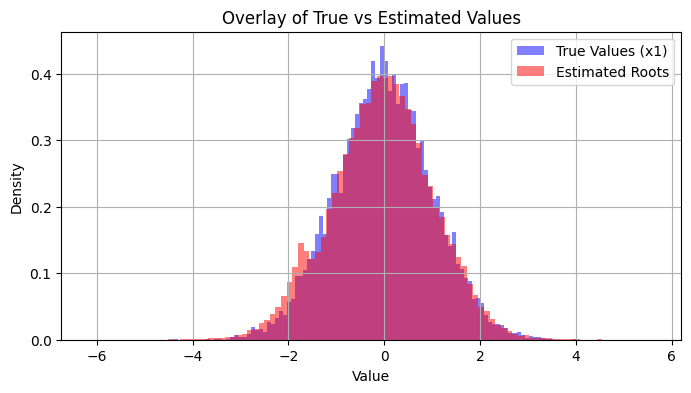

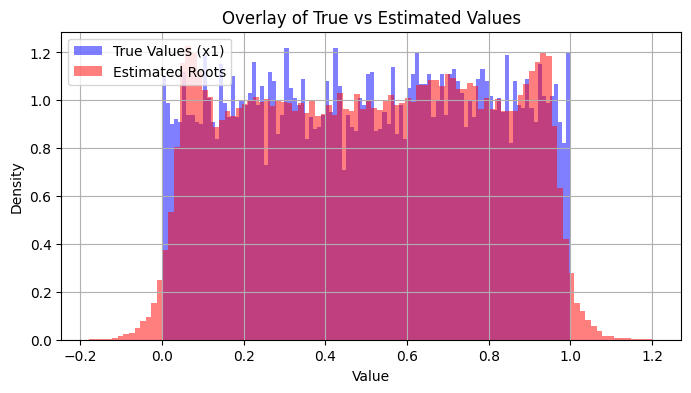

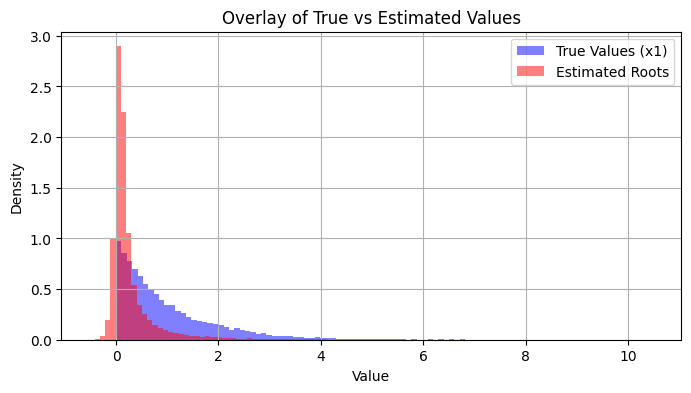

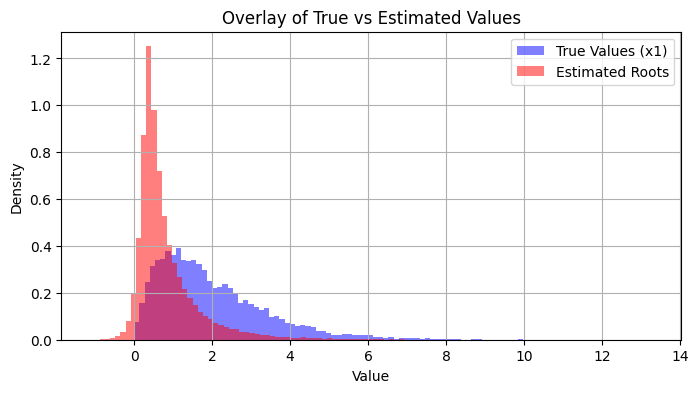

In [35]:
## BUG in the sampling part 
for node in conf_dict.keys():
    root_np = torch.load(f'/home/bule/TramDag/dev_experiment_logs/continous_4vars_1/{node}/sampling/roots.pt').cpu()
    # Plot overlaid histograms
    plt.figure(figsize=(8, 4))
    plt.hist(df[node] , bins=100, alpha=0.5, label='True Values (x1)', color='blue', density=True)
    plt.hist(root_np, bins=100, alpha=0.5, label='Estimated Roots', color='red', density=True)
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.title("Overlay of True vs Estimated Values")
    plt.legend()
    plt.grid(True)
    plt.show()

### BUGFIXING

In [ ]:
### BUGFIX try
works for x1 and x2 x3 has problems , fix 

In [42]:
def bisection_root_finder_in_chunks(f_full, low, high, thetas, shifts, latent_sample, k_min, k_max,
                                     chunk_size=10_000, max_iter=10_000, tol=1e-10):
    roots = []
    n_total = low.shape[0]

    for i in range(0, n_total, chunk_size):
        low_chunk = low[i:i+chunk_size]
        high_chunk = high[i:i+chunk_size]
        thetas_chunk = thetas[i:i+chunk_size]
        shifts_chunk = shifts[i:i+chunk_size]
        latents_chunk = latent_sample[i:i+chunk_size]

        def f_chunk(targets_chunk):
            return vectorized_object_function(
                thetas=thetas_chunk,
                targets=targets_chunk,
                shifts=shifts_chunk,
                latent_sample=latents_chunk,
                k_min=k_min,
                k_max=k_max
            )

        root_chunk = bisection_root_finder(
            f=f_chunk,
            low=low_chunk,
            high=high_chunk,
            max_iter=max_iter,
            tol=tol
        )
        roots.append(root_chunk)

    return torch.cat(roots, dim=0)


In [44]:
import os
import torch
import warnings
from tqdm import tqdm
from torch.utils.data import DataLoader

def merge_outputs(dict_list, skip_nan=True):
    int_outs = []
    shift_outs = []
    skipped_count = 0

    for d in dict_list:
        int_tensor = d['int_out']
        shift_tensor = d['shift_out']

        if skip_nan and torch.isnan(int_tensor).all():
            skipped_count += 1
            continue

        int_outs.append(int_tensor)

        # Unwrap list if needed
        if shift_tensor is not None:
            if isinstance(shift_tensor, list):
                shift_tensor = shift_tensor[0]
            shift_outs.append(shift_tensor)

    if skipped_count > 0:
        warnings.warn(f"{skipped_count} entries with all-NaN 'int_out' were skipped.")

    merged = {
        'int_out': torch.cat(int_outs, dim=0) if int_outs else None,
        'shift_out': torch.cat(shift_outs, dim=0) if shift_outs else None
    }

    return merged

# Start of main loop
node = "x1"
n = 100_000
batch_size = 1
verbose = True

for node in conf_dict:
    print(f'\n----*----------*-------------*--------Sample Node: {node} ------------*-----------------*-------------------*--')

    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    SAMPLING_DIR = os.path.join(NODE_DIR, 'sampling')
    os.makedirs(SAMPLING_DIR, exist_ok=True)

    if check_roots_and_latents(NODE_DIR, verbose=True):
        continue

    skipping_node = False
    if conf_dict[node]['node_type'] != 'source':
        for parent in conf_dict[node]['parents']:
            if not check_roots_and_latents(os.path.join(EXPERIMENT_DIR, parent), verbose=True):
                skipping_node = True
                break

    if skipping_node:
        print(f"Skipping {node} as parent {parent} is not sampled yet.")
        continue

    latent_sample = sample_standard_logistic((n,), device=device)
    if verbose:
        print("sampled latents")

    model_path = os.path.join(NODE_DIR, "best_model.pt")
    tram_model = get_fully_specified_tram_model(node, conf_dict, verbose=True).to(device)
    tram_model.load_state_dict(torch.load(model_path))
    if verbose:
        print("loaded model weights")

    dataset = SamplingDataset(node=node, EXPERIMENT_DIR=EXPERIMENT_DIR, number_of_samples=n, conf_dict=conf_dict, transform=None)
    sample_loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

    output_list = []

    with torch.no_grad():
        for x in tqdm(sample_loader, desc=f"Sampling {node}"):
            x = [xi.to(device) for xi in x]
            int_input, shift_list = preprocess_inputs(x, device=device)
            model_outputs = tram_model(int_input=int_input, shift_input=shift_list)
            output_list.append(model_outputs)

    # Debug print — optional
    if verbose:
        print([{k: (v[0].detach().cpu().numpy() if isinstance(v, list) else v.detach().cpu().numpy())
                for k, v in d.items()} for d in output_list[:3]])

    if conf_dict[node]['node_type'] == 'source':
        theta_single = output_list[0]['int_out'][0]
        theta_single = transform_intercepts_continous(theta_single)
        thetas_expanded = theta_single.repeat(n, 1)
        shifts = torch.zeros(n, device=device)
    else:
        y_pred = merge_outputs(output_list, skip_nan=True)
        shifts = y_pred['shift_out']
        thetas = y_pred['int_out']
        thetas_expanded = transform_intercepts_continous(thetas).squeeze()

        if verbose:
            print(f"thetas_expanded shape: {thetas_expanded.shape}")
            print(f"shifts shape: {shifts.shape}")
            print(f"latent_sample shape: {latent_sample.shape}")

    low = torch.full((n,), -1e5, device=device)
    high = torch.full((n,), 1e5, device=device)
    min_vals = torch.tensor(conf_dict[node]['min'], dtype=torch.float32).to(device)
    max_vals = torch.tensor(conf_dict[node]['max'], dtype=torch.float32).to(device)
    min_max = torch.stack([min_vals, max_vals], dim=0)

    root = bisection_root_finder_in_chunks(
        f_full=vectorized_object_function,  # now unused
        low=low,
        high=high,
        thetas=thetas_expanded,
        shifts=shifts,
        latent_sample=latent_sample,
        k_min=min_max[0],
        k_max=min_max[1],
        chunk_size=1_000,
        max_iter=10_000,
        tol=1e-10
    )


    torch.save(root, os.path.join(SAMPLING_DIR, "roots.pt"))
    torch.save(latent_sample, os.path.join(SAMPLING_DIR, "latents.pt"))



----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--

----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/continous_4vars_1/x3/sampling
sampled latents
>>> TRAM MODEL:
 TramModel(
  (nn_int): ComplexInterceptDefaultTabular(
    (fc1): Linear(in_features=1, out_features=8, bias=True)
    (relu1): ReLU()
    (fc2): Linear(in_features=8, out_features=8, bias=True)
    (relu2): ReLU()
    (fc3): Linear(in_features=8, out_features=20, bias=False)
  )
  (nn_shift): ModuleList(
    (0): ComplexShiftDefaultTabular(
      (fc1): Linear(in_features=1, out_features=8, bias=True)
      (relu1): ReLU()
      (fc2): Linear(in_features=8, out_features=8, bias=True)
      (relu2): ReLU()
      (fc3): Linear(in_fe

/home/bule/TramDag/utils/sampling_tram_data.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_list.append(torch.tensor(tensor))  # ensure tensor type
Sampling x3: 100%|██████████| 100000/100000 [01:00<00:00, 1640.82it/s]


[{'int_out': array([[[-10.593493  ,  50.40356   , -15.699417  ,  -2.5110483 ,
          14.244101  ,   6.2178326 ,  -0.6675455 ,   1.1929871 ,
          11.534098  , -11.499526  ,   4.1230254 ,   2.1306608 ,
          -7.5104094 ,  11.18841   ,   0.31803846,   3.7775853 ,
          -0.45838863,   6.873618  ,   2.9151328 ,   2.9636354 ]]],
      dtype=float32), 'shift_out': array([[[-0.07493146]]], dtype=float32)}, {'int_out': array([[[-10.491332  ,  50.08729   , -15.294149  ,  -2.1920757 ,
          14.202932  ,   6.3657312 ,  -0.57360756,   1.2571217 ,
          11.458454  , -11.335307  ,   4.060691  ,   2.185437  ,
          -7.4228773 ,  11.205774  ,   0.4563501 ,   3.8614945 ,
          -0.34118438,   6.9342194 ,   2.9697485 ,   2.9465842 ]]],
      dtype=float32), 'shift_out': array([[[-0.07426357]]], dtype=float32)}, {'int_out': array([[[-10.582516  ,  50.369568  , -15.655866  ,  -2.476771  ,
          14.239676  ,   6.2337255 ,  -0.65745056,   1.1998787 ,
          11.525969  , 

RuntimeError: The size of tensor a (19) must match the size of tensor b (1000) at non-singleton dimension 2

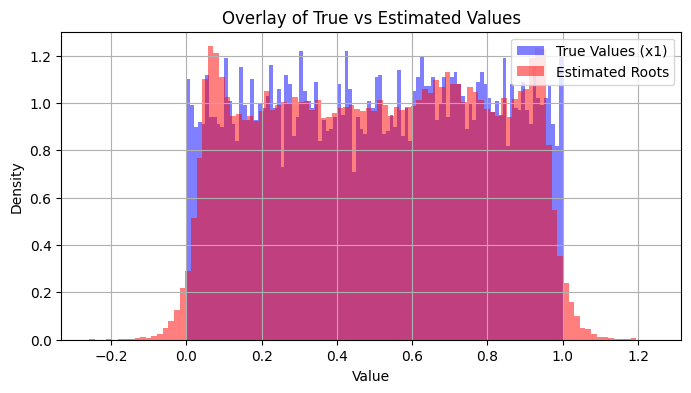

tensor([0.9578, 0.2634, 0.0678,  ..., 0.7800, 0.0124, 0.7443])


In [37]:
## BUG in the sampling part 

# steps to debug
# 1. Check sampling from source with the dataloader

# Move tensors to CPU and convert to NumPy
x1_np = df['x2']       # True values (bimodal)
# Plot overlaid histograms
plt.figure(figsize=(8, 4))
plt.hist(x1_np, bins=100, alpha=0.5, label='True Values (x1)', color='blue', density=True)



root_np = torch.load('/home/bule/TramDag/dev_experiment_logs/continous_4vars_1/x2/sampling/roots.pt').cpu()


plt.hist(root_np, bins=100, alpha=0.5, label='Estimated Roots', color='red', density=True)

plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Overlay of True vs Estimated Values")
plt.legend()
plt.grid(True)
plt.show()
print(root_np)

# 2.
dataset = SamplingDataset(node='x2',EXPERIMENT_DIR=EXPERIMENT_DIR,number_of_samples=10, conf_dict=conf_dict, transform=None)
sample_loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)


## kloading seems to be alright


# # get 1 batch
# for x_batch in sample_loader:
#     print(x_batch)
        

## Chandrupatla

In [ ]:
# @torch.no_grad()
# def chandrupatla_root_finder(f, low, high, max_iter=100, tol=1e-7):
#     a = low.clone()
#     b = high.clone()
#     fa = f(a)
#     fb = f(b)

#     if not torch.all(fa * fb < 0):
#         raise ValueError("Invalid brackets: fa * fb must be < 0")

#     c = a.clone()
#     fc = fa.clone()
#     d = b - a
#     e = d.clone()

#     for _ in range(max_iter):
#         cond = (fa != fc) & (fb != fc)

#         s = torch.where(
#             cond,
#             a * fb * fc / ((fa - fb) * (fa - fc)) +
#             b * fa * fc / ((fb - fa) * (fb - fc)) +
#             c * fa * fb / ((fc - fa) * (fc - fb)),
#             b - fb * (b - a) / (fb - fa)
#         )

#         s = torch.clamp(s, torch.min(a, b), torch.max(a, b))
#         fs = f(s)

#         cond1 = fa * fs < 0

#         c.copy_(b)
#         fc.copy_(fb)

#         a = torch.where(cond1, a, b)
#         fa = torch.where(cond1, fa, fb)

#         b = s
#         fb = fs

#         d, e = e, b - a

#         if torch.max(torch.abs(b - a)) < tol:
#             break

#     return b


# def root_finding_in_chunks(f_full, low, high, chunk_size=1000, **kwargs):
#     results = []
#     n = low.shape[0]
#     for i in range(0, n, chunk_size):
#         l_chunk = low[i:i+chunk_size]
#         h_chunk = high[i:i+chunk_size]
#         f = lambda x: f_full(x, i)
#         roots = chandrupatla_root_finder(f, l_chunk, h_chunk, **kwargs)
#         results.append(roots)
#     return torch.cat(results)

# def vectorized_object_function(thetas, targets, shifts, latent_sample, k_min, k_max):
#     return h_extrapolated_with_shift(thetas, targets, shifts, k_min, k_max) - latent_sample

# def f_full(targets, chunk_start):
#     # slice only the needed chunk of inputs
#     chunk_end = chunk_start + targets.shape[0]
#     return vectorized_object_function(
#         thetas_expanded[chunk_start:chunk_end],
#         targets,
#         shifts[chunk_start:chunk_end],
#         latent_sample[chunk_start:chunk_end],
#         k_min=min_max[0],
#         k_max=min_max[1]
#     )
